In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from licensing import LicensingData
from realestate import RealEstateData
import numpy as np
from scipy.stats import pearsonr
from dynamics import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from matplotlib.lines import Line2D
red_line = Line2D([], [], color='r', lw=3, label='60622')

# Read and preprocess raw data

In [ ]:
# read and preprocess licensing data, then save to hdf
# licensing = LicensingData()
# licensing.save()

# Load data

In [ ]:
# load property values
mvalfah = pd.concat(RealEstateData(), axis=1)

In [ ]:
# load licenses and temporarily exclude those outsize zipcodes for which real estate values are unavailable
licenses = LicensingData.load()
licenses = licenses[licenses['ZIP CODE'].isin(mvalfah.columns)]
licenses.loc[:, 'YEAR'] = licenses['DATE ISSUED'].apply(lambda x: x.year)

In [ ]:
# print most common license codes
license_codes = licenses.groupby('LICENSE CODE')['LICENSE DESCRIPTION'].agg(['count', 'first']).sort_values('count', ascending=False)
license_codes.iloc[:10]

# Preprocessing

In [ ]:
# identify newly issued licenses
new = licenses[np.logical_and(licenses['APPLICATION TYPE']=='ISSUE', licenses['LICENSE STATUS'] == 'AAI')]
renewed = licenses[np.logical_and(licenses['APPLICATION TYPE']=='RENEW', licenses['LICENSE STATUS'] == 'AAI')]
cancelled = licenses[licenses['LICENSE STATUS'].isin(['AAC', 'REV'])]

# compute number of additions/renewals per zip code
criteria = ['DATE ISSUED', 'ZIP CODE', 'LICENSE CODE']
num_additions = new.groupby(criteria).size().groupby(level=[0, 1]).sum().unstack(level=1).resample('1M', axis=0).sum()
num_renewals = renewed.groupby(criteria).size().groupby(level=[0, 1]).sum().unstack(level=1).resample('1M', axis=0).sum()
turnover = cancelled.groupby(criteria).size().groupby(level=[0, 1]).sum().unstack(level=1).resample('1M', axis=0).sum()

# compute annual additions/renewals per zip code
annual_additions = num_additions.resample('1Y', axis=0).sum()
annual_renewals = num_renewals.resample('1Y', axis=0).sum()
annual_turnover = turnover.resample('1Y', axis=0).sum()

# impute 2011/2012 due to licensing reform
annual_additions = annual_additions.drop(annual_renewals.loc['2011'].index)
annual_additions = annual_additions.drop(annual_renewals.loc['2012'].index)
annual_additions = annual_additions.resample('1Y', axis=0).interpolate()
annual_renewals = annual_renewals.drop(annual_renewals.loc['2011'].index)
annual_renewals = annual_renewals.drop(annual_renewals.loc['2012'].index)
annual_renewals = annual_renewals.resample('1Y', axis=0).interpolate()
annual_turnover = annual_turnover.drop(annual_turnover.loc['2011'].index)
annual_turnover = annual_turnover.drop(annual_turnover.loc['2012'].index)
annual_turnover = annual_turnover.resample('1Y', axis=0).interpolate()

# smooth renewals (some are bi-annual)
annual_renewals = annual_renewals.apply(savgol_filter, args=(3, 1))

# Plot license addition/renewal/turnover timeseries

These are the rates of license additions, renewal, and turnover for each zipcode over the past two decades.

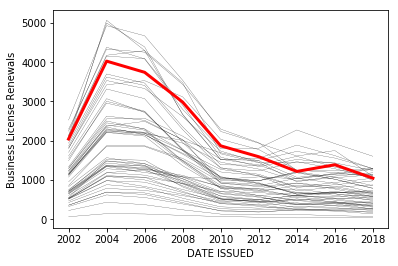

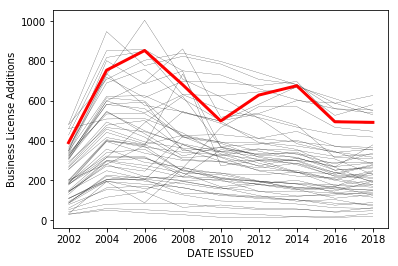

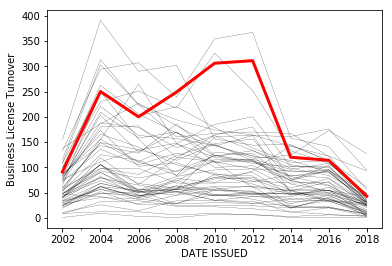

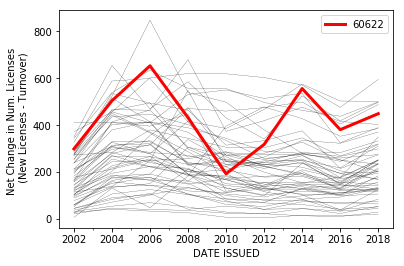

In [81]:
# compute annual additions/renewals per zip code
freq = '2Y'
addition_ts = annual_additions.resample(freq, axis=0).sum()
renewal_ts = annual_renewals.resample(freq, axis=0).sum()
turnover_ts = annual_turnover.resample(freq, axis=0).sum()

# plot license renewals
ax = plot_timeseries(renewal_ts)
ax.set_ylabel('Business License Renewals')
renewal_ts.loc[:, 60622].plot(ax=ax, lw=3, color='r')

# plot license additions
ax = plot_timeseries(addition_ts)
ax.set_ylabel('Business License Additions')
addition_ts.loc[:, 60622].plot(ax=ax, lw=3, color='r')

# plot license turnover
ax = plot_timeseries(turnover_ts)
ax.set_ylabel('Business License Turnover')
turnover_ts.loc[:, 60622].plot(ax=ax, lw=3, color='r')

# plot license growth rate
net_change = (addition_ts-turnover_ts)
ax = plot_timeseries(net_change)
ax.set_ylabel('Net Change in Num. Licenses \n (New Licenses - Turnover)')
ax.set_xlabel('Year')
net_change.loc[:, 60622].plot(ax=ax, lw=3, color='r', label='60622')
ax.legend(handles=[red_line])

# Simple correlation between property values and licensing rates

There is a weak correlation between the annual net change in business licenses and the relative property value.

In [86]:
# normalize and detrend realestate value data
detrended_mvalfah = detrend(normalize_by_baseline(mvalfah, baseline_length=1))

In [87]:
X = net_change
Y = detrended_mvalfah.resample('1Y').mean().loc[X.index, :]
pearsonr(X.values.flatten(), Y.values.flatten())

(0.43210541048175194, 2.415617873086622e-24)